In [1]:
import cv2, numpy as np
import math
import time
import random

from matplotlib import pyplot as plt
%matplotlib inline

from bokeh.plotting import figure #pip install bokeh
from bokeh.io import output_notebook, show, push_notebook


output_notebook()


def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()
    
    
def create_win(frames, scale=1.0) :    
    global myImage
    
    all = []
    for f in frames :
        if len(f.shape ) !=  3 : f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR)
        all.append(f)
    frame = np.vstack(all)
    
    fr=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
    fr=cv2.flip(fr, -1) # because Bokeh flips vertically
    width=fr.shape[1]
    height=fr.shape[0]    

    p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=int(width*scale), height=int(height*scale))    
    myImage = p.image_rgba(image=[fr], x=0, y=0, dw=width, dh=height)
    show(p, notebook_handle=True)   
    
    
def update_win(frames) :
    
    all = []
    for f in frames :
        #print(len(f.shape))
        if len(f.shape ) !=  3 : f = cv2.cvtColor(f, cv2.COLOR_GRAY2BGR)
        all.append(f)
    frame = np.vstack(all)
    
    fr=cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
    fr=cv2.flip(fr, 0)
    myImage.data_source.data['image']=[fr]
    push_notebook()


Loading BokehJS ...

In [14]:
#ORB 는 지역특징점을 검출하기 위해 사용
orb = cv2.ORB_create()

matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING)



images = ['pic/book1.jpg', 'pic/book2.jpg', 'pic/book3.jpg', 'pic/book4.jpg', ] 

database_kp = []
database_desc = []
for name in images :
    img = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
    keypoints, desc = orb.detectAndCompute(img, None) # 특징점(keypoints) 
    database_kp.append(keypoints)
    database_desc.append(desc)
    
#database_kp[0] #첫번 째 책에 대한 keypoint


In [23]:
test = cv2.imread("pic/book4_4test.jpg", cv2.IMREAD_GRAYSCALE)
keypoints, desc = orb.detectAndCompute(test, None)

48.3
42.16
52.48
30.8


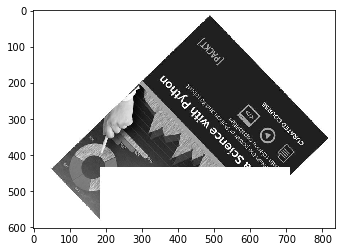

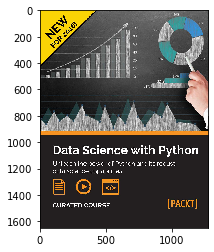

In [24]:
min_distance = 1000
idx = -1
for i in range(len(images)) :   
    matches = matcher.match(desc, database_desc[i])
    matches = sorted(matches, key=lambda x: x.distance)
    good_matches = matches[:50]
    
    #테스트 샘플과 매칭이 잘된 50개 점들의 평균 
    distance = 0
    for d  in good_matches :
        distance += d.distance
    distance /= len(good_matches)    
    print(distance)
        
    #가장 작은 최소의 거리
    if  min_distance > distance :
        min_distance = distance
        idx = i

imshow("", test  )
imshow("", cv2.imread(images[idx])      )

In [79]:
src1 = cv2.imread('pic/box.png', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('pic/box_in_scene.png', cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING) 
#Brute-force matcher create method. NORM_HAMMING 방식으로 

keypoints1, desc1 = orb.detectAndCompute(src1, None)
keypoints2, desc2 = orb.detectAndCompute(src2, None)
#keypoints 는 사진의 특징점(Keypoint)을 검출하는 클래스이며 코너점을 검출한다.
#descriptor는 keypoints에 해당되는 정보로 keypoint와 같은 개수로 생성
#descripotr는 keypoints와 실제 유사도를 판별하기 위한 데이터로 활용 되어 짐.

matches = matcher.match(desc1, desc2)  #서로 다른 이미지의 descriptor를 match
matches = sorted(matches, key=lambda x: x.distance) # Match.distance : Descriptor 간의 거리로 작을수록 더 좋은 결과
good_matches = matches[:50] # 매치 점중 가장 좋은 거리 50개 만 저장 


#일반 BF Matcher 객체가 생성되면 match()와 knnMatch()라는 함수를 사용합니다. 
#첫번째는 가장 좋은 매칭 결과를 반환하고, 두번째 함수는 사용자가 지정한 k개의 가장 좋은 매칭 결과를 반환합니다. 
#특징점을 표시하는 cv2.drawKeypoints()와 같이, 2개의 이미지 간의 동일 특징점을 선으로 연결에 표시해 주는 cv2.drawMatches() 함수와 
#cv2.drawMatchesKnn() 함수가 있습니다.

In [76]:
#Match.queryIdx : 조회 기술자 리스트에 저장된 인덱스(위 예제에서 img2에서 추출한 기술자가 조회 기술자임)
#Match.trainIdx : 연습 기술자 리스트에 저장된 인덱스(위 예제에서 img1에서 추출한 기술자가 연습 기술자임)
#Match.imgIdx : 연습 이미지의 인덱스

pts1 = np.array([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2).astype(np.float32) 
#Match.queryIdx : 조회 기술자 리스트에 저장된 인덱스(위 예제에서 img2에서 추출한 기술자가 조회 기술자임)
#x,y로 이루어진 50개의 점을 3차원(x,1,2)으로 resize
pts2 = np.array([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2).astype(np.float32)
#Match.trainIdx : 연습 기술자 리스트에 저장된 인덱스(위 예제에서 img1에서 추출한 기술자가 연습 기술자임)


print(pts1.shape)  # 50,1,2 #차원수를 50개에 대한 2차원으로 생성
print(pts2.shape)
#print(pts1) # 코너 점들에 대한 좌표가 명시

(50, 1, 2)
(50, 1, 2)


In [29]:
H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC) 
print(H)

[[ 4.85610150e-01 -1.26423343e-01  1.16639863e+02]
 [ 3.62734153e-02  4.76039278e-01  1.58710108e+02]
 [-1.20390936e-04 -1.08741047e-04  1.00000000e+00]]


In [30]:
(h, w) = src1.shape[:2]
corners1 = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2).astype(np.float32)
corners2 = cv2.perspectiveTransform(corners1, H)

print(corners1)
print(corners2)

[[[  0.   0.]]

 [[  0. 222.]]

 [[323. 222.]]

 [[323.   0.]]]
[[[116.63986 158.71011]]

 [[ 90.76499 270.93124]]

 [[261.93488 294.67987]]

 [[284.5573  177.32181]]]


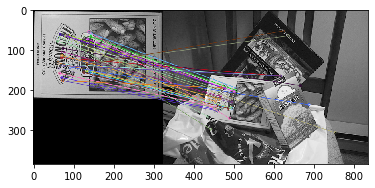

In [31]:
dst = cv2.drawMatches(src1, keypoints1, src2, keypoints2, good_matches, None,
                         flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow("", dst)

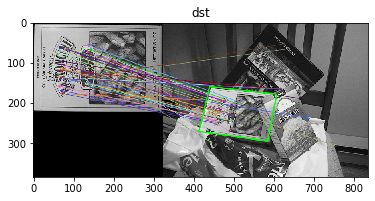

In [32]:
corners3 = corners2 + np.float32([w, 0]) 

cv2.polylines(dst, [np.int32(corners3)], True, (0, 255, 0), 2, cv2.LINE_AA)

imshow('dst', dst)

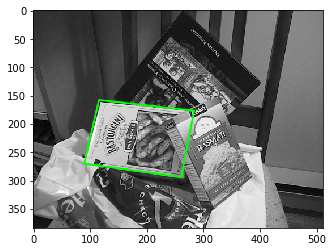

In [33]:
test = cv2.imread('pic/box_in_scene.png')

cv2.polylines(test, [np.int32(corners2)], True , (0,255,0), 2, cv2.LINE_AA)
imshow('',test)

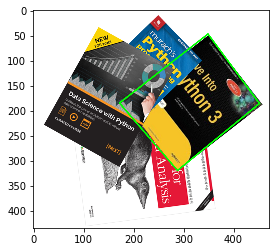

In [70]:
def findBook(query, scene) : 
    
    src1 = cv2.cvtColor(query, cv2.COLOR_BGR2GRAY)
    src2 = cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY)
    
    keypoints1, desc1 = orb.detectAndCompute(src1, None)
    keypoints2, desc2 = orb.detectAndCompute(src2, None)

    matches = matcher.match(desc1, desc2)
    matches = sorted(matches, key=lambda x: x.distance)
    good_matches = matches[:50]

    pts1 = np.array([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2).astype(np.float32)
    pts2 = np.array([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2).astype(np.float32)

    H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC)

    (h, w) = src1.shape[:2]
    corners1 = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2).astype(np.float32)
    corners2 = cv2.perspectiveTransform(corners1, H)
    
    return np.int32(corners2)




q = cv2.imread('pic/book2.jpg')
s = cv2.imread('pic/box_in_scene3.png')

corner = findBook(q, s)

cv2.polylines(s, [corner], True, (0, 255, 0), 2, cv2.LINE_AA)

imshow("", s)

(50, 1, 2)
(50, 1, 2)
[[ 1.64246147e+00 -3.89245913e+00  3.43264756e+02]
 [ 5.94186744e-01 -1.37640081e+00  1.19473953e+02]
 [ 4.86208006e-03 -1.14150976e-02  1.00000000e+00]]
[[[  0.   0.]]

 [[  0. 324.]]

 [[259. 324.]]

 [[259.   0.]]]
[[[343.26477 119.47395]]

 [[340.15002 120.98608]]

 [[342.1971  119.91662]]

 [[340.22464 120.99805]]]


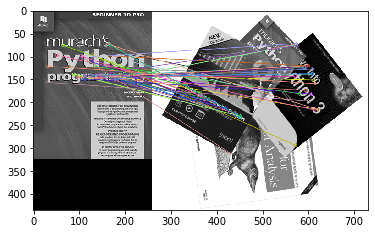

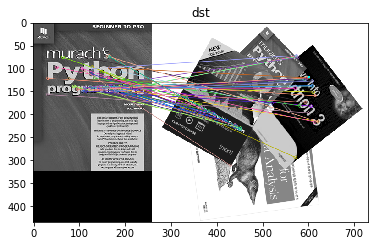

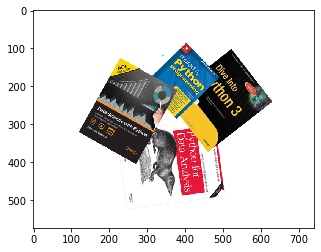

In [72]:
src1 = cv2.imread('pic/book3.jpg', cv2.IMREAD_GRAYSCALE)
src2 = cv2.imread('pic/box_in_scene3.png', cv2.IMREAD_GRAYSCALE)


orb = cv2.ORB_create()
matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING) 
#Brute-force matcher create method. NORM_HAMMING 방식으로 

keypoints1, desc1 = orb.detectAndCompute(src1, None) # keypoints 와 descriptor 추출
keypoints2, desc2 = orb.detectAndCompute(src2, None)


matches = matcher.match(desc1, desc2)
matches = sorted(matches, key=lambda x: x.distance)
good_matches = matches[:50]

pts1 = np.array([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2).astype(np.float32)
pts2 = np.array([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2).astype(np.float32)

print(pts1.shape)  # 50,1,2 #차원수를 50개에 대한 2차원으로 생성
print(pts2.shape)
#print(pts1) # 코너 점들에 대한 좌표가 명시


H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC) #노이즈가 많으면 제대로 값이 안잡힐 수 있다
print(H)

(h, w) = src1.shape[:2]
corners1 = np.array([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2).astype(np.float32)
corners2 = cv2.perspectiveTransform(corners1, H)

print(corners1)
print(corners2)

dst = cv2.drawMatches(src1, keypoints1, src2, keypoints2, good_matches, None,
                         flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow("", dst)


corners3 = corners2 + np.float32([w, 0]) 

cv2.polylines(dst, [np.int32(corners3)], True, (255, 255, 0), 2, cv2.LINE_AA)

imshow('dst', dst)


test = cv2.imread('pic/box_in_scene2.png')

cv2.polylines(test, [np.int32(corners2)], True , (255,255,0), 2, cv2.LINE_AA) #선 그리는 함수
imshow('',test)